# Exercise 07 - Finite element method

We use finite elements to discretize a continuous domain and solve the linear elastic problem on this domain in this exercise. There is a prepared Python class for finite element calculations called `FEM` and you can import it via `from torchfem import planar`. 

A finite element model consists of `nodes` (tensor with shape Nx2), `elements`(list with shape Mx4), `forces` (tensor with shape Nx2) acting on nodes, constraints (boolean tensor with shape Nx2) defining for each degree of freedom wether it is constrained (`True`) or not (`False`). In addition, we need to specify the material behavior with Young's modulus `E` and Poisson ration `nu`. These arguments are passed into the `FEM` class to create a new `FEM` object.

In [15]:
from math import sqrt

import torch
from torchfem import Planar
from torchfem.elements import Quad1
from torchfem.materials import IsotropicPlaneStress

torch.set_default_dtype(torch.double)

## Task 1 - A rectangular plate
You should create a unit square FEM model named `square` with $N$ elements per direction, i.e. $N^2$ quad elements in the entire model. All degrees of freedom are constrained at the left hand side of the square and all nodes at the right hand side should experience a force $F=1.0/N$. The Young's modulus is $E=1000.0$ and the Poisson ratio is $\nu=0.3$. The thickness of all elements is 0.1.

a) Create the model and plot it with `square.plot()`.

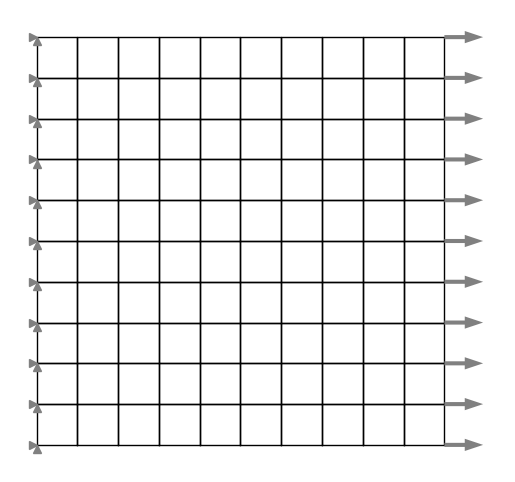

In [16]:
# Define Material
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

# Create nodes
N = 10
n1 = torch.linspace(0.0, 1, N + 1)
n2 = torch.linspace(0.0, 1, N + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])
elements = torch.tensor(elements)

# Model
square = Planar(nodes, elements, material)

# Define sets
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
top = nodes[:, 1] == 1.0
bottom = nodes[:, 1] == 0.0

# Load at tip
square.forces[right, 0] = 1.0 / N
square.forces[right & bottom, 0] = 0.5 / N
square.forces[right & top, 0] = 0.5 / N


# Constrained displacement at left end
square.constraints[left, :] = True

# Define thickness
square.thickness[:] = 0.1

# Plot
square.plot(node_labels=True)

b) Solve displacement for this thickness distribution via `u, f = square.solve(d)`. Plot the displacement magnitude on the deformed mesh with `square.plot(u, node_property=...)`. 

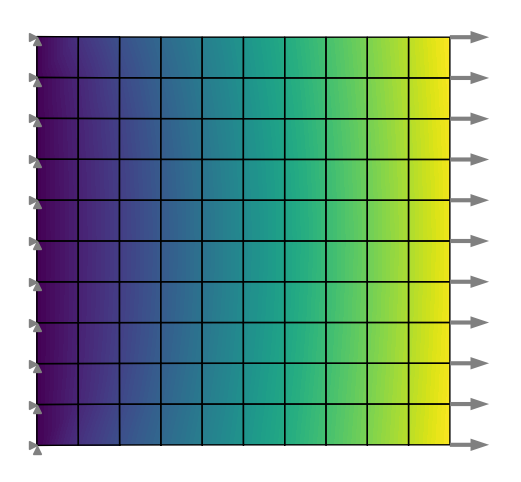

In [17]:
# Solve
u, f = square.solve()

# Plot
square.plot(u, node_property=torch.norm(u, dim=1))

c) Given an element, define a function `strain(element)` that computes the strain at the center of that element.

In [18]:
# A quad object contains the shape functions N and B
quad = Quad1()


def strain(element):
    # Extract node positions of element
    xe = square.nodes[element, :]

    # Extract displacement degrees of freedom
    ue = u[element, :].ravel()

    # Set position of evaluation
    xi = torch.tensor([0.0, 0.0])

    # Jacobian
    J = quad.B(xi) @ xe

    # Compute B
    B = torch.linalg.inv(J) @ quad.B(xi)

    # Compute D
    D = torch.zeros((3, 2 * quad.nodes))
    D[0, 0::2] = B[0, :]
    D[1, 1::2] = B[1, :]
    D[2, 0::2] = B[1, :]
    D[2, 1::2] = B[0, :]

    # Compute strain
    return D @ ue


# Test with first element
print(strain(square.elements[0]))

tensor([ 0.0108, -0.0015,  0.0045])


d) Using the previous `strain` function, compute stresses in all elements and plot the von Mises stress in the square.

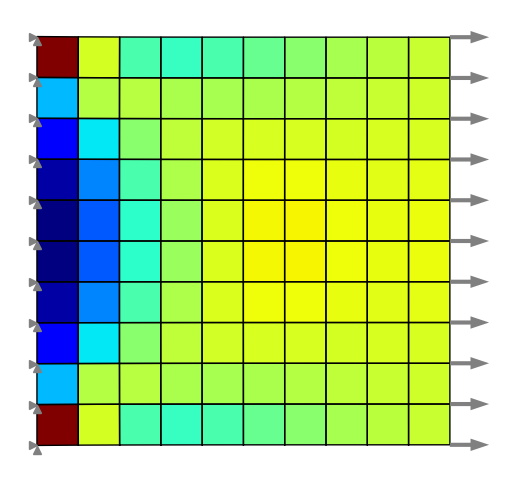

In [19]:
mises = []

for element in square.elements:
    stress = material.C() @ strain(element)
    mises.append(
        sqrt(
            stress[0] ** 2 + stress[1] ** 2 - stress[0] * stress[1] + 3 * stress[2] ** 2
        )
    )

# Plot the results
square.plot(u, element_property=mises, cmap="jet")